In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:

df = pd.read_csv("spam.csv", encoding="latin-1")[['v1', 'v2']]
df.columns = ['label', 'text']

# Convert labels: spam = 1, ham = 0
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(preprocess)

# TF-IDF Vectorization
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['clean_text'])
y = df['label'].values

# Train–test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Class distribution:")
print(df['label'].value_counts())
print()


Class distribution:
label
0    4825
1     747
Name: count, dtype: int64



In [7]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

train_pred = stump.predict(X_train)
test_pred = stump.predict(X_test)

print("Decision Stump — Train accuracy:", accuracy_score(y_train, train_pred))
print("Decision Stump — Test accuracy:", accuracy_score(y_test, test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_pred))
print("\nStump performs weak because it splits on only ONE feature — too simple for text data.\n")



Decision Stump — Train accuracy: 0.8837783262284048
Decision Stump — Test accuracy: 0.8923766816143498
Confusion Matrix:
[[930  36]
 [ 84  65]]

Stump performs weak because it splits on only ONE feature — too simple for text data.



In [9]:
T = 15
n = X_train.shape[0]
w = np.ones(n) / n   # initial weights

alphas = []
errors = []

for t in range(T):
    stump_t = DecisionTreeClassifier(max_depth=1)
    stump_t.fit(X_train, y_train, sample_weight=w)
    pred_t = stump_t.predict(X_train)

    misclassified = (pred_t != y_train).astype(int)
    error_t = np.dot(w, misclassified)

    # Avoid division by zero
    error_t = max(error_t, 1e-10)

    alpha_t = 0.5 * np.log((1 - error_t) / error_t)

    # Print required outputs
    print(f"\nIteration {t+1}")
    print("Misclassified indices:", np.where(misclassified == 1)[0][:15], "...")
    print("Weights of misclassified samples (first 10):", w[misclassified == 1][:10])
    print("Alpha:", alpha_t)

    # Update weights
    w = w * np.exp(alpha_t * misclassified)
    w = w / w.sum()

    alphas.append(alpha_t)
    errors.append(error_t)

print("\n--- Manual AdaBoost Training Complete ---\n")




Iteration 1
Misclassified indices: [ 14  42  49  50  59  62  86  93  96 100 103 115 121 140 142] ...
Weights of misclassified samples (first 10): [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]
Alpha: 1.0143534603557114

Iteration 2
Misclassified indices: [  9  15  22  31  39  49  59  66  76  88  93 114 115 121 123] ...
Weights of misclassified samples (first 10): [0.00018631 0.00018631 0.00018631 0.00018631 0.00018631 0.00051376
 0.00051376 0.00018631 0.00018631 0.00018631]
Alpha: 0.7967295311027793

Iteration 3
Misclassified indices: [ 15  31  39  49  50  59  66  76  86  88  93  96 100 114 115] ...
Weights of misclassified samples (first 10): [0.00034276 0.00034276 0.00034276 0.00094518 0.00042609 0.00094518
 0.00034276 0.00034276 0.00042609 0.00034276]
Alpha: 0.4431708323478377

Iteration 4
Misclassified indices: [  9  15  22  31  39  49  50  59  62  66  76  86  88 100 114] ...
Weights of misclassified samples (first 

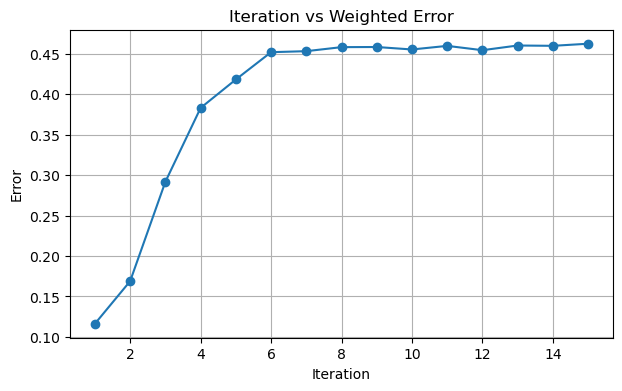

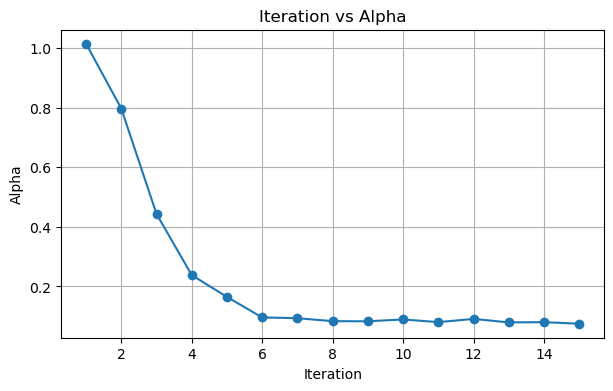

In [11]:
# PLOT: iteration vs weighted error
plt.figure(figsize=(7, 4))
plt.plot(range(1, T+1), errors, marker='o')
plt.title("Iteration vs Weighted Error")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.grid()
plt.show()

# PLOT: iteration vs alpha
plt.figure(figsize=(7, 4))
plt.plot(range(1, T+1), alphas, marker='o')
plt.title("Iteration vs Alpha")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.grid()
plt.show()


In [13]:
# Final predictions using weighted voting
train_preds = np.zeros(len(y_train))
test_preds = np.zeros(len(y_test))

for t in range(T):
    stump_t = DecisionTreeClassifier(max_depth=1)
    stump_t.fit(X_train, y_train, sample_weight=np.ones(n)/n)
    train_preds += alphas[t] * stump_t.predict(X_train)
    test_preds += alphas[t] * stump_t.predict(X_test)

train_preds = (train_preds >= 0.5).astype(int)
test_preds = (test_preds >= 0.5).astype(int)

print("Manual AdaBoost — Train accuracy:", accuracy_score(y_train, train_preds))
print("Manual AdaBoost — Test accuracy:", accuracy_score(y_test, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))


Manual AdaBoost — Train accuracy: 0.8837783262284048
Manual AdaBoost — Test accuracy: 0.8923766816143498
Confusion Matrix:
[[930  36]
 [ 84  65]]


In [15]:
sk_ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42
)
sk_ada.fit(X_train, y_train)

sk_train_pred = sk_ada.predict(X_train)
sk_test_pred = sk_ada.predict(X_test)

print("\nSklearn AdaBoost — Train accuracy:", accuracy_score(y_train, sk_train_pred))
print("Sklearn AdaBoost — Test accuracy:", accuracy_score(y_test, sk_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, sk_test_pred))

print("\nComparison:")
print("Manual AdaBoost is usually less accurate because:")
print("• It uses fewer rounds (T=15).")
print("• It does not reuse the actual learned stumps from each round.")
print("• sklearn uses optimized boosting and more trees.")

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Sklearn AdaBoost — Train accuracy: 0.9845187345748261
Sklearn AdaBoost — Test accuracy: 0.9766816143497757
Confusion Matrix:
[[963   3]
 [ 23 126]]

Comparison:
Manual AdaBoost is usually less accurate because:
• It uses fewer rounds (T=15).
• It does not reuse the actual learned stumps from each round.
• sklearn uses optimized boosting and more trees.
